In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from IPython.display import display
from scipy import *

import matplotlib.pyplot as plt
import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter

In [ ]:

import pywt
print(pywt.families(short=False))


['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


## Reading UCI-HAR

In [27]:
def read_signals_ucihar(filename):
    with open(filename, 'r') as fp:
        print("Reading in file: {}".format(fp))
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels_ucihar(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities
 
def load_ucihar_data(folder):
    train_folder = folder + 'train/Inertial Signals/'
    test_folder = folder + 'test/Inertial Signals/'
    labelfile_train = folder + 'train/y_train.txt'
    labelfile_test = folder + 'test/y_test.txt'
    train_signals, test_signals = [], []
    for input_file in sort(os.listdir(train_folder)):
        signal = read_signals_ucihar(train_folder + input_file)
        train_signals.append(signal)
    train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
    for input_file in sort(os.listdir(test_folder)):
        signal = read_signals_ucihar(test_folder + input_file)
        test_signals.append(signal)
    test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
    train_labels = read_labels_ucihar(labelfile_train)
    test_labels = read_labels_ucihar(labelfile_test)
    return train_signals, train_labels, test_signals, test_labels

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [28]:
folder_ucihar = '/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/' 
train_signals, train_labels, test_signals, test_labels = load_ucihar_data(folder_ucihar)

INPUT_SIGNAL_FILES = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:])) #number of labels (activities)

print("Training dataset contains {} signals, each one of length {} and {} different components ".format(no_signals_train, no_steps_train, no_components_train))
print("Training labels have the following distribution:\n {}".format(Counter(train_labels[:])))
print("Test dataset contains {} signals, each one of length {} and {} different components ".format(no_signals_test, no_steps_test, no_components_test))
#print("Test labels have the following distribution:\n {}".format(Counter(test_labels[:])))

print("Activity labels originally have the following unique values:\n {}".format(unique(test_labels)))
#Need to ensure activity labels start at zero instead of one for later use in keras
train_labels[:] = [x - 1 for x in train_labels]
test_labels[:] = [x - 1 for x in test_labels]
print("Activity labels now have the following unique values:\n {}".format(unique(test_labels)))

#Define activity label key
activities_description = {
    0: 'walking',
    1: 'walking upstairs',
    2: 'walking downstairs',
    3: 'sitting',
    4: 'standing',
    5: 'laying'
}

#Shuffle data while retaining mapping with labels
train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))
print("Shuffling data!")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.sort is deprecated and will be removed in SciPy 2.0.0, use numpy.sort instead


Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/train/Inertial

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.sort is deprecated and will be removed in SciPy 2.0.0, use numpy.sort instead


Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI HAR Dataset/test/Inertial Signals/bo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.unique is deprecated and will be removed in SciPy 2.0.0, use numpy.unique instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.unique is deprecated and will be removed in SciPy 2.0.0, use numpy.unique instead


In [29]:
print(np.array(train_signals).shape)
print(np.array(test_signals).shape)

(7352, 128, 9)
(2947, 128, 9)


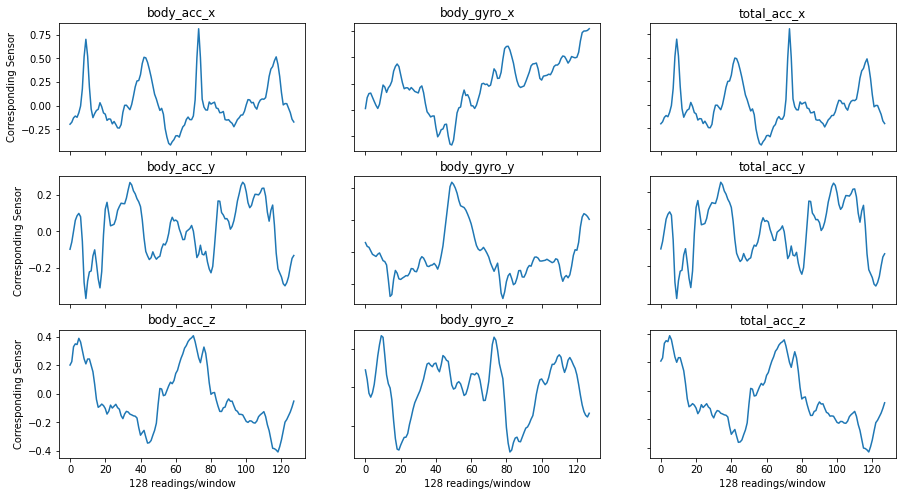

In [ ]:
one_sample=arr_train_signals[7351] # Any random val

fig, axs = plt.subplots(3, 3,figsize=(15,8))
axs[0, 0].plot(one_sample[:,0])
axs[0, 0].set_title('body_acc_x')

axs[1, 0].plot(one_sample[:,1])
axs[1, 0].set_title('body_acc_y')

axs[2, 0].plot(one_sample[:,2])
axs[2, 0].set_title('body_acc_z')

axs[0, 1].plot(one_sample[:,3])
axs[0, 1].set_title('body_gyro_x')

axs[1, 1].plot(one_sample[:,4])
axs[1, 1].set_title('body_gyro_y')

axs[2, 1].plot(one_sample[:,5])
axs[2, 1].set_title('body_gyro_z')

axs[0, 2].plot(one_sample[:,6])
axs[0, 2].set_title('total_acc_x')

axs[1, 2].plot(one_sample[:,7])
axs[1, 2].set_title('total_acc_y')

axs[2, 2].plot(one_sample[:,8])
axs[2, 2].set_title('total_acc_z')

for ax in axs.flat:
    ax.set(xlabel='128 readings/window', ylabel='Corresponding Sensor')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/wavelet_1.jpg')

## Feature Extraction with CWT

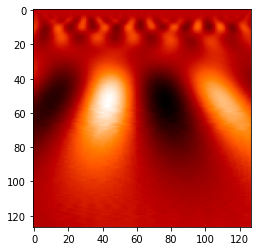

In [ ]:
# Example execution of cwt.
scales = range(1,128)
waveletname = 'morl'
train_size = 1

sample_cwt= np.ndarray(shape=(1, 127, 127, 9)) #Çünkü kaç scale varsa o kadar dimension ekleniyor.
for j in range(0,9):
  signal = uci_har_signals_train[0, :, j] # I used first sample as an example
  coeff, freq = pywt.cwt(signal, scales, waveletname, 1) # Tam olarak bu satır cwt'yi execute ediyor.
  coeff_ = coeff[:,:127]
  sample_cwt[0, :, :, j] = coeff_ # Sonra coefficientleri topluyoruz

plt.imshow(np.squeeze(sample_cwt)[:,:,3], cmap='gist_heat')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/wavelet_2.jpg')



Label is :  5


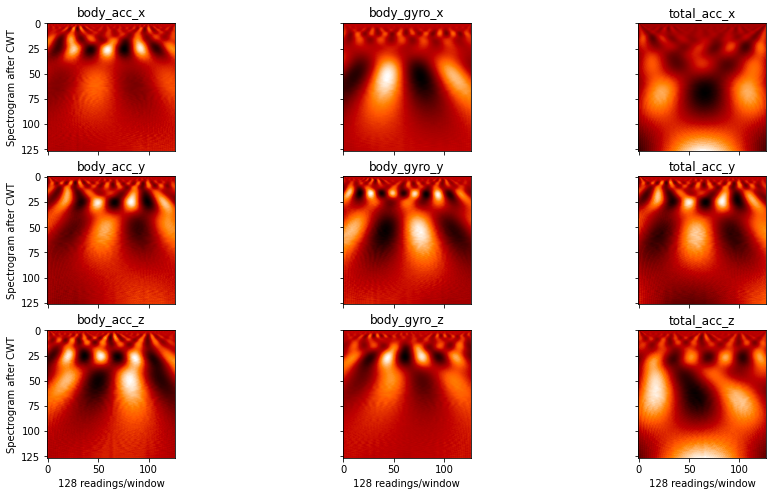

In [ ]:
fig, axs = plt.subplots(3, 3,figsize=(15,8))
axs[0, 0].imshow(np.squeeze(sample_cwt)[:,:,0], cmap='gist_heat')
axs[0, 0].set_title('body_acc_x')

axs[1, 0].imshow(np.squeeze(sample_cwt)[:,:,1], cmap='gist_heat')
axs[1, 0].set_title('body_acc_y')

axs[2, 0].imshow(np.squeeze(sample_cwt)[:,:,2], cmap='gist_heat')
axs[2, 0].set_title('body_acc_z')

axs[0, 1].imshow(np.squeeze(sample_cwt)[:,:,3], cmap='gist_heat')
axs[0, 1].set_title('body_gyro_x')

axs[1, 1].imshow(np.squeeze(sample_cwt)[:,:,4], cmap='gist_heat')
axs[1, 1].set_title('body_gyro_y')

axs[2, 1].imshow(np.squeeze(sample_cwt)[:,:,5], cmap='gist_heat')
axs[2, 1].set_title('body_gyro_z')

axs[0, 2].imshow(np.squeeze(sample_cwt)[:,:,6], cmap='gist_heat')
axs[0, 2].set_title('total_acc_x')

axs[1, 2].imshow(np.squeeze(sample_cwt)[:,:,7], cmap='gist_heat')
axs[1, 2].set_title('total_acc_y')

axs[2, 2].imshow(np.squeeze(sample_cwt)[:,:,8], cmap='gist_heat')
axs[2, 2].set_title('total_acc_z')

for ax in axs.flat:
    ax.set(xlabel='128 readings/window', ylabel='Spectrogram after CWT')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

print("Label is : ", labels_train[0])
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/wavelet_3.jpg')




In [31]:
scales = range(1,128)
waveletname = 'morl'

#Take subset of data when training with CPU

train_size = 7352
#train_size = len(train_signals)
print(train_size)
Xtrain_CWT = np.ndarray(shape=(train_size, 127, 127, 9))

for ii in range(0,train_size):
    if ii % 3500 == 0:
        print(ii)
    for jj in range(0,9):
        signal = train_signals[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        Xtrain_CWT[ii, :, :, jj] = coeff_

test_size = 1000
#test_size = len(test_signals)
Xtest_CWT = np.ndarray(shape=(test_size, 127, 127, 9))
for ii in range(0,test_size):
    if ii % 500 == 0:
        print(ii)
    for jj in range(0,9):
        signal = test_signals[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        Xtest_CWT[ii, :, :, jj] = coeff_

7352
0
3500
7000
0
500


In [32]:
import keras
y_train = list(train_labels[:train_size])
y_test = list(test_labels[:test_size])

#Specify spectrogram image dimensions
img_x = 127
img_y = 127
img_z = 9
num_classes = 6

#reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
#because the spectrograms are essentially grayscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)

#convert the data to the right type
#x_train = x_train.reshape(x_train.shape[0], img_x, img_y, img_z)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, img_z)
Xtrain_CWT = Xtrain_CWT.astype('float32')
Xtest_CWT = Xtest_CWT.astype('float32')

print('Xtrain_CWT shape:', Xtrain_CWT.shape)
print(Xtrain_CWT.shape[0], 'train samples')
print(Xtest_CWT.shape[0], 'test samples')

#convert class vectors to binary class matrices - this is for use in categorical_crossentropy loss below
Ytrain_CWT = keras.utils.to_categorical(y_train, num_classes)
Ytest_CWT = keras.utils.to_categorical(y_test, num_classes)

Xtrain_CWT shape: (7352, 127, 127, 9)
7352 train samples
1000 test samples


In [33]:
x_train = Xtrain_CWT
y_train = Ytrain_CWT
x_test = Xtest_CWT
y_test = Ytest_CWT

In [34]:
np.save('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Xtrain_data_cwt.npy', x_train)    # .npy extension is added if not given
np.save('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Ytrain_data_cwt.npy', y_train)    # .npy extension is added if not given
np.save('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Xtest_data_cwt.npy', x_test)    # .npy extension is added if not given
np.save('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Ytest_data_cwt.npy', y_test)    # .npy extension is added if not given


In [35]:
 #x_train=np.load('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Xtrain_data_cwt.npy')
 #y_train=np.load('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Ytrain_data_cwt.npy')
 #x_test=np.load('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Xtest_data_cwt.npy')
 #y_test=np.load('/content/gdrive/My Drive/Colab Notebooks/WUCI/UCI-HAR-PROCESSED/Ytest_data_cwt.npy')

In [36]:
img_x = 127
img_y = 127
img_z = 9
num_classes = 6

input_shape = (img_x, img_y, img_z)

## CNN

In [39]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History,EarlyStopping 
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras import backend as K



def recall_m(true_Y, pred_Y):
        TP = K.sum(K.round(K.clip(true_Y * pred_Y, 0, 1)))
        possible_pos = K.sum(K.round(K.clip(true_Y, 0, 1)))
        rec = TP / (possible_pos + K.epsilon())
        return rec

def precision_m(true_Y, pred_Y):
        true_positives = K.sum(K.round(K.clip(true_Y * pred_Y, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(pred_Y, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(true_Y, pred_Y):
    pres = precision_m(true_Y, pred_Y)
    rec = recall_m(true_Y, pred_Y)
    return 2*((pres*rec)/(pres+rec+K.epsilon()))

In [40]:
from keras.layers import LSTM
from keras import Model

img_x = 127
img_y = 127
img_z = 9

class CNN(object):
  def __init__(self,
               class_num=6,
               last_activation='softmax'):

      self.class_num = 6
      self.last_activation = last_activation

  def forward(self):
    
      img_inputs  = keras.Input((img_x,img_y,img_z))
      conv_1 = keras.layers.Conv2D(32, (5, 5), activation='relu', strides=(1, 1))(img_inputs)
      maxpool_1 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(conv_1)

      conv_2 = keras.layers.Conv2D(64, (5, 5), activation='relu', strides=(2, 2))(maxpool_1)
      maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)

      flatten = keras.layers.Flatten()(conv_2)
      dense_1 = keras.layers.Dense(512, activation='relu')(flatten)


      output = Dense(self.class_num, activation=self.last_activation)(dense_1)
      model = Model(inputs=img_inputs, outputs=output)
      return model


def CNN_train(X_train,y_train,X_test,y_test):
  
  history = History()

  num_classes = 6
  batch_size = 16
  epochs = 50
  early_stopping = [EarlyStopping(monitor='val_loss',min_delta=0,restore_best_weights=True, patience=7,verbose=1, mode='auto')]


  model=CNN().forward()
  model.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer=keras.optimizers.Adam(), 
                metrics=['accuracy',f1_m,precision_m, recall_m])

  history=model.fit(X_train, y_train, batch_size=batch_size, 
            epochs=epochs, verbose=1, 
            validation_split=0.1, 
            callbacks=early_stopping)

  

  loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=1)
  print(" CNN Training Loss: {:.4f}".format(loss))
  print(" CNN Training Accuracy: {:.4f}".format(accuracy))
  print(" CNN Training f1 score: {:.4f}".format(f1_score))
  print(" CNN Training Precision: {:.4f}".format(precision))
  print(" CNN Training Recall: {:.4f}".format(recall))


  loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)
  print(" CNN Test Loss: {:.4f}".format(loss))
  print(" CNN Test Accuracy: {:.4f}".format(accuracy))
  print(" CNN Test f1 score: {:.4f}".format(f1_score))
  print(" CNN Test Precision: {:.4f}".format(precision))
  print(" CNN Test Recall: {:.4f}".format(recall))


  test_score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

  number_of_epochs_it_ran = len(history.history['accuracy'])

  fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train acc')
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test acc')
  axarr[0].set_xlabel('Number of Epochs', fontsize=18)
  axarr[0].set_ylabel('Accuracy', fontsize=18)
  axarr[0].set_ylim([0,1])
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train acc')
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test acc')
  axarr[1].set_xlabel('Number of Epochs', fontsize=18)
  axarr[1].set_ylabel('Accuracy', fontsize=18)
  axarr[1].set_ylim([0.80,1])
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/acc_cnn_2_1.jpg')
  plt.legend()
  plt.show()

  fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['loss'], label='train loss')
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['val_loss'], label='test loss')
  axarr[0].set_xlabel('Number of Epochs', fontsize=18)
  axarr[0].set_ylabel('Loss', fontsize=18)
  axarr[0].set_ylim([0,1])
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['loss'], label='train loss')
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['val_loss'], label='test loss')
  axarr[1].set_xlabel('Number of Epochs', fontsize=18)
  axarr[1].set_ylabel('Loss', fontsize=18)
  axarr[1].set_ylim([0,0.3])
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/loss_cnn_2_1.jpg')
  plt.legend()
  plt.show()

  plt.figure(figsize=[8, 6])											
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train acc')
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test acc')
  plt.xlabel('Number of Epochs', fontsize=18)
  plt.ylabel('Accuracy', fontsize=18)
  plt.title('Accuracy Curves', fontsize=18)
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/acc_cnn_2_2.jpg')
  plt.legend()
  plt.show()

  plt.figure(figsize=[8, 6])											# loss curves
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['loss'], label='train loss')
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['val_loss'], label='test loss')
  plt.xlabel('Number of Epochs', fontsize=18)
  plt.ylabel('Loss', fontsize=18)
  plt.title('Loss Curves', fontsize=18)
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/loss_cnn_2_2.jpg')
  plt.legend()
  plt.show()


Epoch 1/50
414/414 [==============================] - 5s 11ms/step - loss: 0.3581 - accuracy: 0.8877 - f1_m: 0.8830 - precision_m: 0.9050 - recall_m: 0.8735 - val_loss: 0.2422 - val_accuracy: 0.9062 - val_f1_m: 0.9048 - val_precision_m: 0.9062 - val_recall_m: 0.9035
Epoch 2/50
414/414 [==============================] - 4s 10ms/step - loss: 0.1702 - accuracy: 0.9392 - f1_m: 0.9391 - precision_m: 0.9413 - recall_m: 0.9370 - val_loss: 0.1566 - val_accuracy: 0.9266 - val_f1_m: 0.9266 - val_precision_m: 0.9280 - val_recall_m: 0.9253
Epoch 3/50
414/414 [==============================] - 4s 10ms/step - loss: 0.1475 - accuracy: 0.9465 - f1_m: 0.9464 - precision_m: 0.9484 - recall_m: 0.9446 - val_loss: 0.2038 - val_accuracy: 0.9348 - val_f1_m: 0.9325 - val_precision_m: 0.9345 - val_recall_m: 0.9307
Epoch 4/50
414/414 [==============================] - 4s 10ms/step - loss: 0.1572 - accuracy: 0.9451 - f1_m: 0.9450 - precision_m: 0.9470 - recall_m: 0.9432 - val_loss: 0.1383 - val_accuracy: 0.9416 

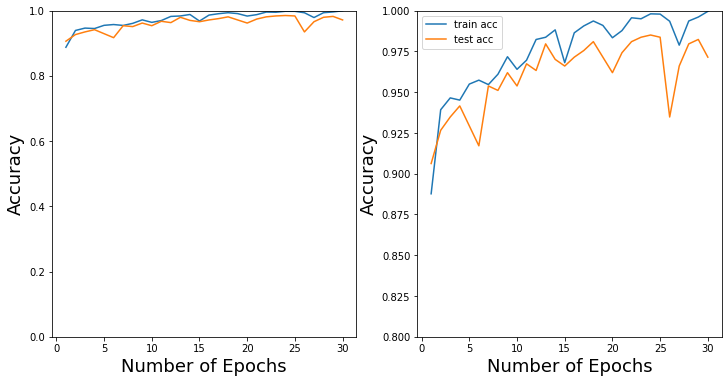

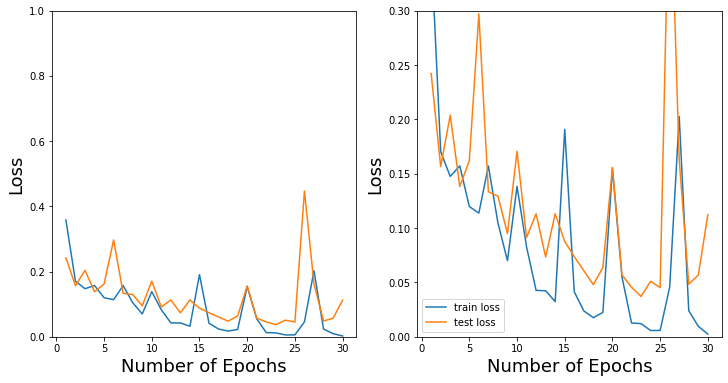

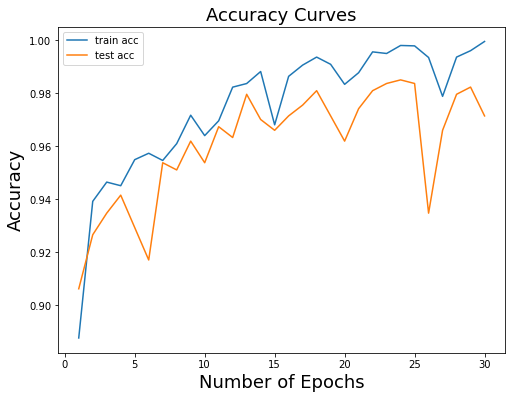

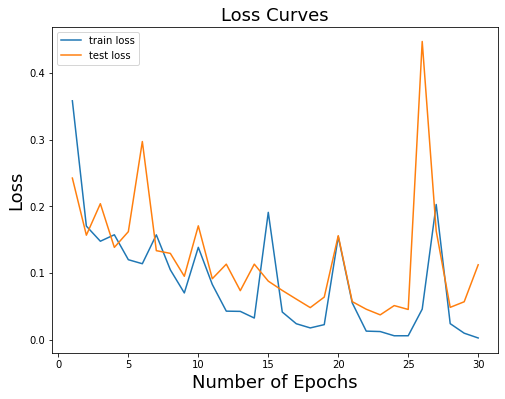

In [41]:
#batch,epoch,lr must be added to the function params.
history_cnnlstm=CNN_train(x_train,y_train,x_test,y_test)

## CNNLSTM

In [42]:
# calısan


from keras.layers import LSTM,Lambda,TimeDistributed
from keras import Model

img_x = 127
img_y = 127
img_z = 9

class CNN(object):
  def __init__(self,
               class_num=6,
               last_activation='softmax'):

      self.class_num = 6
      self.last_activation = last_activation

  def forward(self):
    

      
      #maxpool_2 = Lambda(lambda y: keras.backend.squeeze(y, 0))(maxpool_2)

      #flatten = keras.layers.Flatten()(maxpool_2)


      img_inputs  = keras.Input((img_x,img_y,img_z))
      
      #x = Lambda(lambda y: keras.backend.squeeze(y, 0))(img_inputs)
      print("img_inputs", img_inputs.shape)

      
      conv_1 = keras.layers.Conv2D(32, (5, 5), activation='relu', strides=(1, 1))(img_inputs)
      maxpool_1 = keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(conv_1)

      print("maxpool1",maxpool_1.shape)

      conv_2 = keras.layers.Conv2D(64, (5, 5), activation='relu', strides=(2, 2))(maxpool_1)
      maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)

      #flatten = keras.layers.Flatten()(maxpool_2)

      print("maxpool2",maxpool_2.shape)

      #reshaped = Lambda(lambda y: keras.backend.squeeze(y, 0))(maxpool_1)
      
      reshaped = Lambda(lambda y: keras.backend.reshape(y, (-1,14*14,64)))(maxpool_2) #Burasına shape'i maxppool2.shape[1]**2 tarzı bir şey olucak. bunu düzelt.

      #reshaped=keras.backend.reshape(maxpool_1, (-1,61*61,32))
      print(reshaped.shape, "reshaped")
      
      x=LSTM(61, return_sequences=False)(reshaped) 
      
      print(x.shape, "lstm")

      #x=Lambda(lambda y: keras.backend.expand_dims(x, 0))(x)

      #x = keras.backend.expand_dims(x, axis=0)

      #x = keras.layers.Flatten()(x)

      #Iputs needs to be reshaped to be [samples, time steps, features]



      print("flatten",x.shape)

      dense_1 = keras.layers.Dense(32, activation='relu')(x)
      
      print("dense_out",dense_1.shape)

      #dense_1 = Lambda(lambda y: keras.backend.squeeze(y, 0))(dense_1)


      #dense_1=keras.backend.reshape(dense_1, (None,32))
      print("ok")
      output = Dense(self.class_num, activation=self.last_activation)(dense_1)
      print("output",output.shape)
 
      model = Model(inputs=img_inputs, outputs=output)

      #print(keras.backend.squeeze(maxpool_2,0))
      #maxpool_2=keras.backend.squeeze(maxpool_2,0)
      #maxpool_2 = Lambda(lambda y: keras.backend.squeeze(y, 0))(maxpool_2)

      #x = LSTM(128, return_sequences=False)(flatten)  # LSTM or GRU
      #print("x:", x.shape)

      return model


def CNN_train(X_train,y_train,X_test,y_test):
  
  history = History()

  num_classes = 6
  batch_size = 64
  epochs = 50
  early_stopping = [EarlyStopping(monitor='val_loss',min_delta=0,restore_best_weights=True, patience=7,verbose=1, mode='auto')]
 


  model=CNN().forward()
  model.compile(loss=keras.losses.categorical_crossentropy, 
                optimizer=keras.optimizers.Adam(), 
                metrics=['accuracy',f1_m,precision_m, recall_m])

  history=model.fit(X_train, y_train, batch_size=batch_size, 
            epochs=epochs, verbose=1, 
            validation_split=0.1, 
            callbacks=early_stopping)

  

  loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=1)
  print(" CNN Training Loss: {:.4f}".format(loss))
  print(" CNN Training Accuracy: {:.4f}".format(accuracy))
  print(" CNN Training f1 score: {:.4f}".format(f1_score))
  print(" CNN Training Precision: {:.4f}".format(precision))
  print(" CNN Training Recall: {:.4f}".format(recall))


  loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)
  print(" CNN Test Loss: {:.4f}".format(loss))
  print(" CNN Test Accuracy: {:.4f}".format(accuracy))
  print(" CNN Test f1 score: {:.4f}".format(f1_score))
  print(" CNN Test Precision: {:.4f}".format(precision))
  print(" CNN Test Recall: {:.4f}".format(recall))


  test_score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

  number_of_epochs_it_ran = len(history.history['accuracy'])

  fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train acc')
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test acc')
  axarr[0].set_xlabel('Number of Epochs', fontsize=18)
  axarr[0].set_ylabel('Accuracy', fontsize=18)
  axarr[0].set_ylim([0,1])
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train acc')
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test acc')
  axarr[1].set_xlabel('Number of Epochs', fontsize=18)
  axarr[1].set_ylabel('Accuracy', fontsize=18)
  axarr[1].set_ylim([0.80,1])
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/acc_cnnlstm_1.jpg')
  plt.legend()
  plt.show()

  fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['loss'], label='train loss')
  axarr[0].plot(range(1, number_of_epochs_it_ran+1), history.history['val_loss'], label='test loss')
  axarr[0].set_xlabel('Number of Epochs', fontsize=18)
  axarr[0].set_ylabel('Loss', fontsize=18)
  axarr[0].set_ylim([0,1])
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['loss'], label='train loss')
  axarr[1].plot(range(1, number_of_epochs_it_ran+1), history.history['val_loss'], label='test loss')
  axarr[1].set_xlabel('Number of Epochs', fontsize=18)
  axarr[1].set_ylabel('Loss', fontsize=18)
  axarr[1].set_ylim([0,0.3])
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/loss_cnnlstm_1.jpg')
  plt.legend()
  plt.show()

  plt.figure(figsize=[8, 6])											
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['accuracy'], label='train acc')
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['val_accuracy'], label='test acc')
  plt.xlabel('Number of Epochs', fontsize=18)
  plt.ylabel('Accuracy', fontsize=18)
  plt.title('Accuracy Curves', fontsize=18)
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/acc_cnnlstm_2.jpg')
  plt.legend()
  plt.show()

  plt.figure(figsize=[8, 6])											# loss curves
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['loss'], label='train loss')
  plt.plot(range(1, number_of_epochs_it_ran+1), history.history['val_loss'], label='test loss')
  plt.xlabel('Number of Epochs', fontsize=18)
  plt.ylabel('Loss', fontsize=18)
  plt.title('Loss Curves', fontsize=18)
  plt.savefig('/content/gdrive/My Drive/Colab Notebooks/WUCI/pic/loss_cnnlstm_2.jpg')
  plt.legend()
  plt.show()


img_inputs (None, 127, 127, 9)
maxpool1 (None, 61, 61, 32)
maxpool2 (None, 14, 14, 64)
(None, 196, 64) reshaped
(None, 61) lstm
flatten (None, 61)
dense_out (None, 32)
ok
output (None, 6)
Epoch 1/50
104/104 [==============================] - 4s 41ms/step - loss: 0.7423 - accuracy: 0.7195 - f1_m: 0.6373 - precision_m: 0.7804 - recall_m: 0.5667 - val_loss: 0.5105 - val_accuracy: 0.7948 - val_f1_m: 0.7923 - val_precision_m: 0.8212 - val_recall_m: 0.7656
Epoch 2/50
104/104 [==============================] - 3s 31ms/step - loss: 0.4541 - accuracy: 0.8151 - f1_m: 0.8122 - precision_m: 0.8460 - recall_m: 0.7819 - val_loss: 0.3895 - val_accuracy: 0.8424 - val_f1_m: 0.8349 - val_precision_m: 0.8545 - val_recall_m: 0.8164
Epoch 3/50
104/104 [==============================] - 3s 31ms/step - loss: 0.3661 - accuracy: 0.8608 - f1_m: 0.8569 - precision_m: 0.8752 - recall_m: 0.8399 - val_loss: 0.3153 - val_accuracy: 0.8845 - val_f1_m: 0.8815 - val_precision_m: 0.8980 - val_recall_m: 0.8659
Epoch 4/50


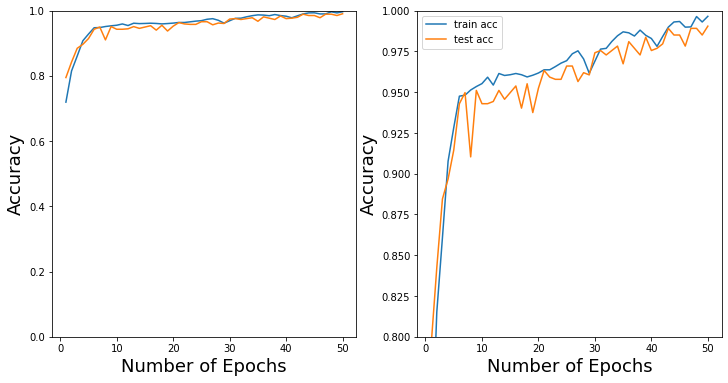

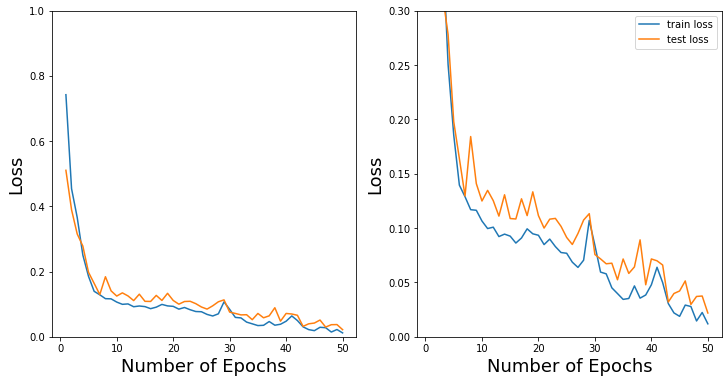

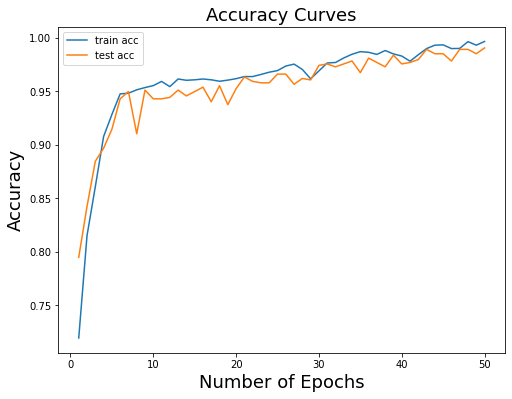

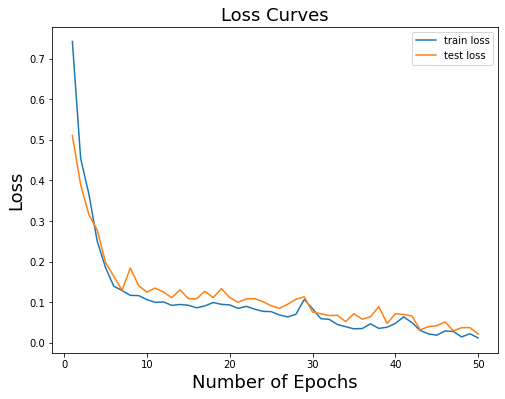

In [44]:
#batch,epoch,lr must be added to the function params.
history_cnnlstm=CNN_train(x_train,y_train,x_test,y_test)